## **Quantum Computing for Option Pricing - Challenge Solution**

 ### Dependencies and imports 

We developed this solution within a conda environment (miniconda) running Python 3.11.2 and the following libraries: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.algorithms.optimizers import SPSA
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
import step1
import step2

### Understading Black-Scholes

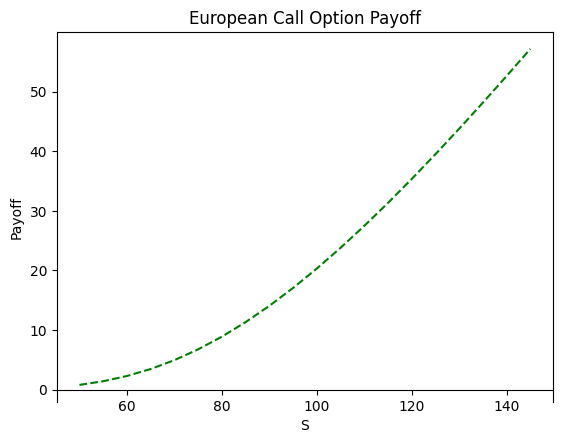

In [2]:
# Parameters
K = 100 # strike price
sigma = 0.4 # volatility in %
T= 1
r = 0.1
Smin = 50
Smax = 150

#Define range of stock price
S = np.arange(Smin,Smax,5)

#Define the underlying strike price
K = 100

fig, ax = plt.subplots()
ax.spines['bottom'].set_position('zero')
ax.plot(S, step1.black_scholes_european_call_payoff(S, K, T, r, sigma), '--', color='g')
plt.xlabel('S')
plt.ylabel('Payoff')
plt.title('European Call Option Payoff')
plt.show()

### **Step 1**: Build the ansatz circuit and the hamiltonian

For simplicity, we'll use the proposed ansatz:

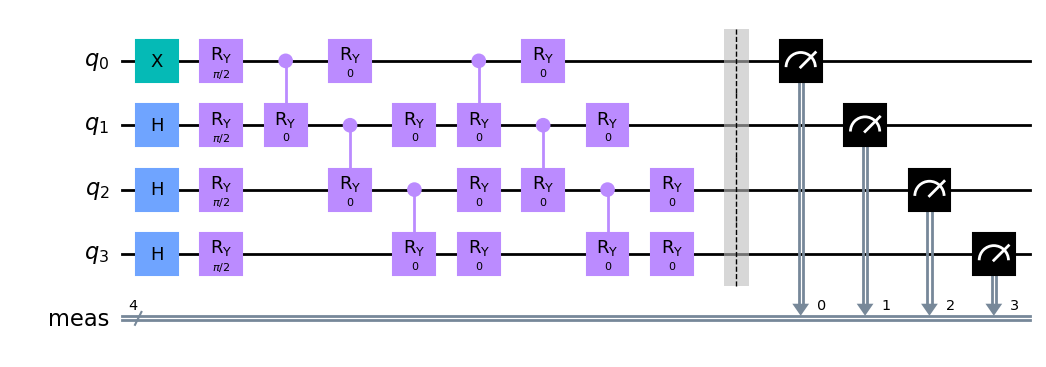

In [3]:
n_qbits=4
rep = 2

params = step1.get_init_params(n_qbits,rep)
qc = step1.ansatz(params,n_qbits,rep)

display(qc.draw('mpl'))

### **Step 2**: Build the initial state for the hybrid quantum-classical algorithm

In [4]:
strike_price = 6
backend = Aer.get_backend('aer_simulator')
optimizer = SPSA(maxiter=1e3)

target_distr = step2.create_target_distr(n_qbits, strike_price)


In [5]:
def cost_func(params):
    """Compares the output distribution of our circuit with
    parameters `params` to the target distribution."""
    # Create circuit instance with paramters and simulate it
    qc = step1.ansatz(params, n_qbits, rep)
    qc_t = transpile(qc, backend)
    result = backend.run(qc_t).result()
    # Get the counts for each measured state, and convert
    # those counts into a probability dict
    output_distr = step2.counts_to_distr(result.get_counts())
    # Calculate the cost as the distance between the output
    # distribution and the target distribution
    cost = sum(
        abs(target_distr.get(i, 0) - output_distr.get(i, 0))
        for i in range(2**n_qbits)
    )
    return cost

    

In [6]:
# optimization
result = optimizer.minimize(fun=cost_func,x0=params)

In [7]:
qc = step1.ansatz(result.x, n_qbits,rep)
qc_t = transpile(qc,backend)


final_result = backend.run(qc_t, shots=int(1e5)).result()
counts = final_result.get_counts()

output_distr = step2.counts_to_distr(counts)
output_amplitudes = step2.get_sorted_amplitudes(output_distr)

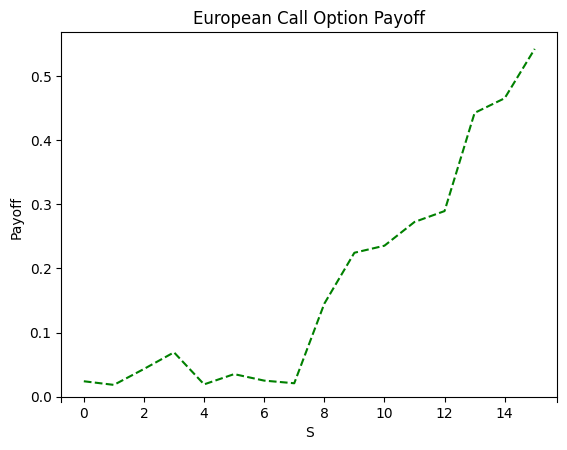

In [8]:
fig, ax = plt.subplots()
ax.spines['bottom'].set_position('zero')
ax.plot(output_amplitudes.keys(), output_amplitudes.values(), '--', color='g')
plt.xlabel('S')
plt.ylabel('Payoff')
plt.title('European Call Option Payoff')
plt.show()

### **Step 3**: Simulate the hybrid quantum-classical routine to price an European call option

### **Bonus points**:

- Run the hybrid quantum-classical on a QPU (optimize for given QPU connectivity). Reason whether you need state tomography, reason if possible to extract the information of interest (only the price call at the current date) with alternatives that require less expensive techniques. On a QPU or QASM  simulator, you only have access to short-estimated probabilities.

- Reason how to extend the algorithm to other type of options or to a multi-dimensional BS model.

- Implement Montecarlo or Finite differences schemes to solve the simple option pricing exercise. A classical baseline to compare with is useful. Argue where does the hybrid quantum algortihm stand in terms of error, runtime and numerical stability or others.